In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

In [2]:
# تنظیم مسیر فایل داده‌های پاک‌سازی شده
INPUT_FILE = '../data/cleaned_accident_data.csv'

# بارگذاری داده‌ها
df = pd.read_csv(INPUT_FILE)
print(f"✅ Data Loaded: {df.shape}")

# نمایش توزیع هدف (تعداد هر نوع شدت تصادف)
print("\nTarget Distribution:")
print(df['Accident_Severity'].value_counts())

✅ Data Loaded: (24622, 53)

Target Distribution:
Accident_Severity
Slight     16450
Serious     6173
Fatal       1999
Name: count, dtype: int64


In [3]:
# تعریف لیست ویژگی‌های پایه
base_features = ['Day_of_Week', 'Road_Type', 'Speed_limit', 'Light_Conditions', 'Weather_Conditions', 'Urban_or_Rural_Area']
target = 'Accident_Severity'

# بررسی وجود ستون‌های Cluster و Density
optional_features = ['Cluster', 'Density']
available_optionals = [f for f in optional_features if f in df.columns]

features = base_features + available_optionals

# استخراج ساعت
if 'Time' in df.columns:
    df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.hour
    features.append('Hour')

# ایجاد model_df برای رفع خطای NameError
model_df = df[features + [target]].dropna().copy()

# تبدیل متغیرهای متنی به عدد
le = LabelEncoder()
for col in model_df.select_dtypes(include='object').columns:
    if col != target:
        model_df[col] = le.fit_transform(model_df[col])

# نگاشت هدف به اعداد
target_map = {'Slight': 0, 'Serious': 1, 'Fatal': 2}
model_df['Target_Encoded'] = model_df[target].map(target_map)

print(f"✅ پیش‌پردازش انجام شد. ویژگی‌های نهایی: {features}")

✅ پیش‌پردازش انجام شد. ویژگی‌های نهایی: ['Day_of_Week', 'Road_Type', 'Speed_limit', 'Light_Conditions', 'Weather_Conditions', 'Urban_or_Rural_Area', 'Hour']


In [4]:
# جداسازی ورودی و خروجی
X = model_df[features]
y = model_df['Target_Encoded']

# تقسیم داده به آموزش و تست
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# تعریف و آموزش مدل‌ها
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='mlogloss')
lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, objective='multiclass', verbose=-1)

print("در حال آموزش مدل‌ها...")
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
print("✅ هر دو مدل با موفقیت آموزش دیدند.")

در حال آموزش مدل‌ها...
✅ هر دو مدل با موفقیت آموزش دیدند.


In [5]:
xgb_preds = xgb_model.predict(X_test)
lgb_preds = lgb_model.predict(X_test)

target_names = ['Slight', 'Serious', 'Fatal']
print("\n--- LightGBM Performance ---")
print(classification_report(y_test, lgb_preds, target_names=target_names))

print("\n--- XGBoost Performance ---")
print(classification_report(y_test, xgb_preds, target_names=target_names))


--- LightGBM Performance ---
              precision    recall  f1-score   support

      Slight       0.70      0.96      0.81      3290
     Serious       0.50      0.16      0.24      1235
       Fatal       0.79      0.03      0.05       400

    accuracy                           0.68      4925
   macro avg       0.66      0.38      0.37      4925
weighted avg       0.66      0.68      0.60      4925


--- XGBoost Performance ---
              precision    recall  f1-score   support

      Slight       0.70      0.96      0.81      3290
     Serious       0.51      0.15      0.23      1235
       Fatal       0.75      0.02      0.04       400

    accuracy                           0.68      4925
   macro avg       0.65      0.38      0.36      4925
weighted avg       0.65      0.68      0.60      4925



In [6]:
import pickle

# ذخیره مدل LightGBM
with open('lgb_model.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

# ذخیره مدل XGBoost
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

print("✅ هر دو مدل با موفقیت ذخیره شدند: lgb_model.pkl و xgb_model.pkl")

✅ هر دو مدل با موفقیت ذخیره شدند: lgb_model.pkl و xgb_model.pkl


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26956\860200963.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Accident_Severity', data=df, palette='viridis', order=['Slight', 'Serious', 'Fatal'])


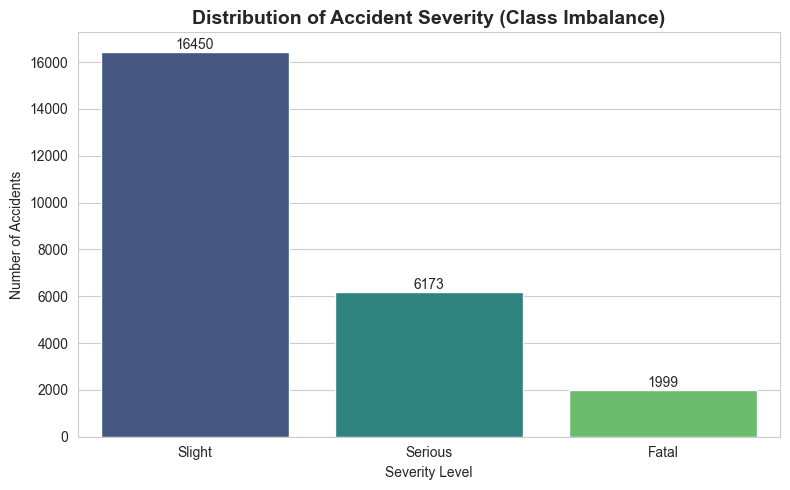

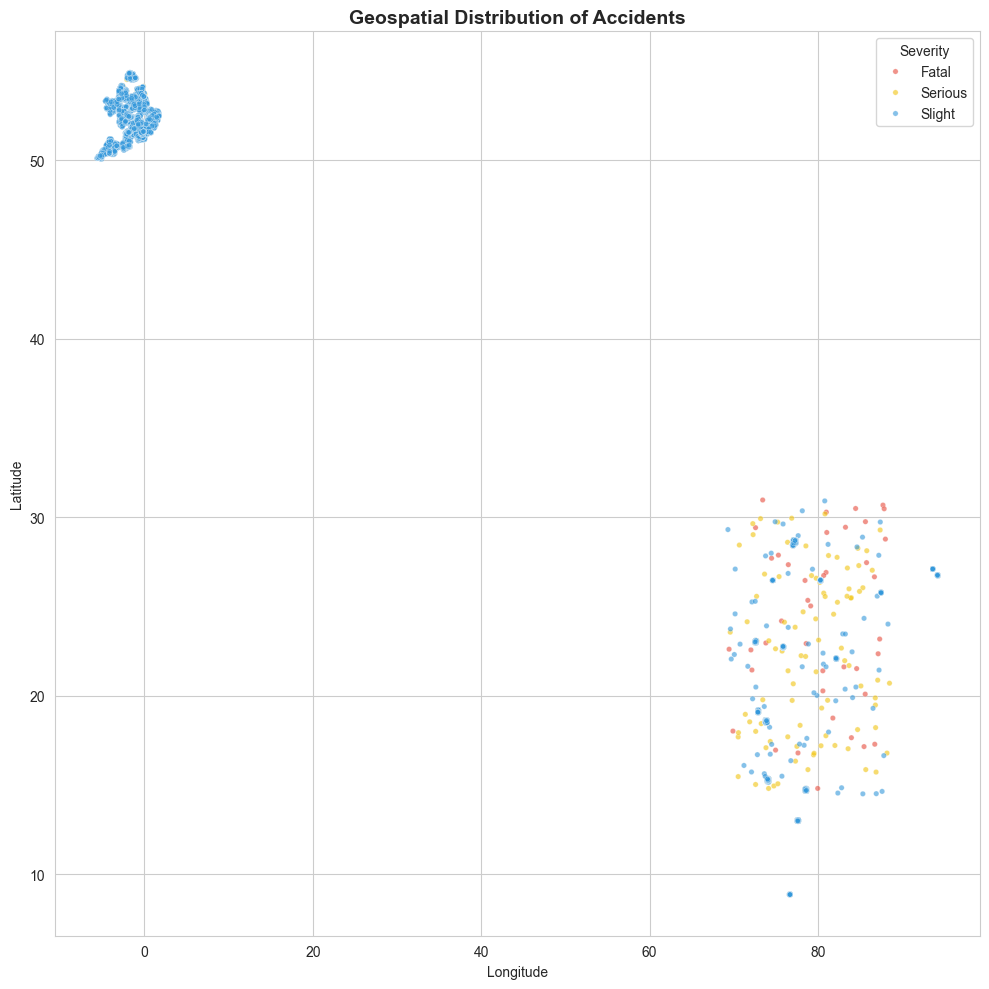

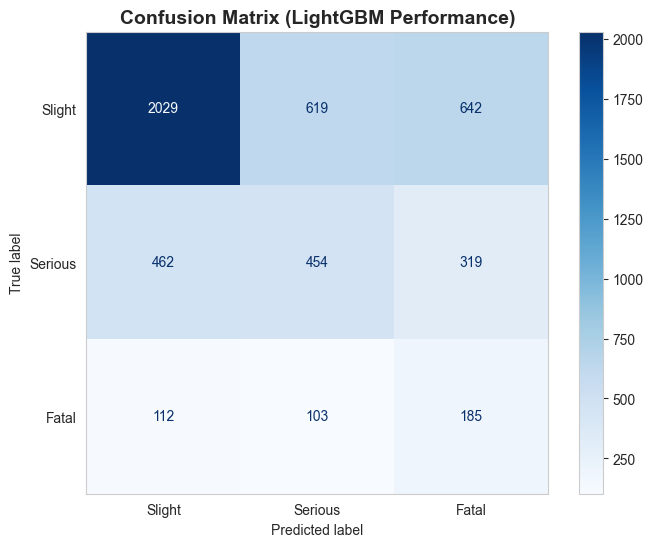

<Figure size 1000x600 with 0 Axes>

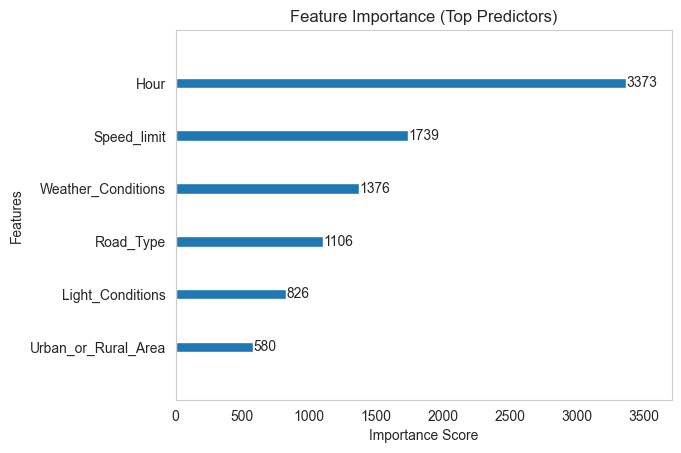

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# تنظیم استایل نمودارها
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

# 1. بارگذاری داده‌ها (مسیر فایل را چک کنید)
try:
    df = pd.read_csv('../data/cleaned_accident_data.csv')
except:
    df = pd.read_csv('data/cleaned_accident_data.csv') # مسیر جایگزین

# ==========================================
# نمودار ۱: عدم توازن داده‌ها (برای تشریح مسئله)
# ==========================================
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Accident_Severity', data=df, palette='viridis', order=['Slight', 'Serious', 'Fatal'])
plt.title('Distribution of Accident Severity (Class Imbalance)', fontsize=14, fontweight='bold')
plt.xlabel('Severity Level')
plt.ylabel('Number of Accidents')
# اضافه کردن اعداد روی ستون‌ها
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.tight_layout()
plt.show()

# ==========================================
# نمودار ۲: نقشه پراکندگی (برای تشریح مسئله)
# ==========================================
plt.figure(figsize=(10, 10))
# رسم نقاط (تصادفات سطحی با رنگ آبی و شفافیت بالا، مرگبار با قرمز و پررنگ)
sns.scatterplot(x='Longitude', y='Latitude', hue='Accident_Severity', data=df, 
                palette={'Slight': '#3498db', 'Serious': '#f1c40f', 'Fatal': '#e74c3c'},
                alpha=0.6, s=15)
plt.title('Geospatial Distribution of Accidents', fontsize=14, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

# ==========================================
# آماده‌سازی مدل برای نمودارهای خروجی
# ==========================================
# استخراج ساعت و پیش‌پردازش سریع برای رسم نمودار
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.hour.fillna(0).astype(int)
features = ['Speed_limit', 'Light_Conditions', 'Weather_Conditions', 'Road_Type', 'Urban_or_Rural_Area', 'Hour']
target = 'Accident_Severity'

# تبدیل داده‌های متنی به عددی
le = LabelEncoder()
df_model = df.copy()
for col in features:
    if df_model[col].dtype == 'object':
        df_model[col] = le.fit_transform(df_model[col].astype(str))

target_map = {'Slight': 0, 'Serious': 1, 'Fatal': 2}
df_model['Target_Encoded'] = df_model[target].map(target_map)

# آموزش مدل (سریع)
X = df_model[features]
y = df_model['Target_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = lgb.LGBMClassifier(random_state=42, class_weight='balanced', verbose=-1)
model.fit(X_train, y_train)

# ==========================================
# نمودار ۳: ماتریس درهم‌ریختگی (برای نتایج مدل)
# ==========================================
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Slight', 'Serious', 'Fatal'])
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix (LightGBM Performance)', fontsize=14, fontweight='bold')
plt.grid(False)
plt.show()

# ==========================================
# نمودار ۴: اهمیت ویژگی‌ها (برای نتایج مدل)
# ==========================================
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, importance_type='split', max_num_features=10, 
                    title='Feature Importance (Top Predictors)', xlabel='Importance Score', grid=False)
plt.show()